# Import Python Package/Library

In [1]:
# Learning on how to prepare PascalVOC to Yolov5 format
# Import Required libaries

import numpy as np # manage on linear algebra
import pandas as pd # data processing, CSV file I/O

from pathlib import Path #Represent file system path

#Manage DOM(The Document Object Model) -> API XML Document
from xml.dom.minidom import parse

from shutil import copyfile #High-Level Operation on Files

import os #Provide function to interact with OS

#Test on os.walk function
# for dirname, _, filenames in os.walk('/home/jarupong/Desktop/helmetDetection'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# Preparing For Dataset

In [ ]:
#Prepare directory for Yolov5 format
!mkdir -p Dataset/labels
!mkdir -p Dataset/images

In [2]:
#Config on class of object in model
classes = ['helmet','head','person']

# Function for preprocess XML to yolov5 format

In [3]:
#This function will transform PasvalVOC to Yolov5 format
#by parse input and calculate to BB algorithm.
def convertFromXML(parsed_img_size, box):
    x1=int(box[0])
    y1=int(box[1])
    x2=int(box[2])
    y2=int(box[3])

    dw = np.float32(1. / int(parsed_img_size[0]) )
    dh = np.float32(1. / int(parsed_img_size[1]) )

    w = x2 - x1
    h = y2 -y1
    x = x1 + (w/2)
    y = y1 + (h/2)

    x = x * dw
    w = w * dw
    y = y * dh
    h = h *dh

    return [x, y, w, h]

In [4]:
#This function will create new annotation file in Yolov5 format
def save_txt_file(img_jpg_file_name, parsed_img_size, label_box):
    save_file_name = '/home/jarupong/Desktop/helmetDetection/Dataset/labels/' + img_jpg_file_name +'.txt'
    print(save_file_name)

    with open(save_file_name, 'a+') as file_path:
        for box in label_box:

            class_num = classes.index(box[0])

            yolov5_box = convertFromXML(parsed_img_size, box[1:])

            file_path.write(f"{class_num} {yolov5_box[0]} {yolov5_box[1]} {yolov5_box[2]} {yolov5_box[3]}\n")

        file_path.flush()
        file_path.close()

In [5]:
#This function will access and parsing on original PasvalVOC format 
def get_xml_data(file_path, img_xml_file):
    img_path = file_path + '/' + img_xml_file + '.xml'
    (print(img_path))

    dom = parse(img_path)
    root = dom.documentElement
    img_name = root.getElementsByTagName("filename")[0].childNodes[0].data
    img_size = root.getElementsByTagName("size")[0]
    objects = root.getElementsByTagName("object")
    img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
    img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
    img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data

    label_box = []
    for box in objects:
        class_name = box.getElementsByTagName("name")[0].childNodes[0].data
        x1 = box.getElementsByTagName("xmin")[0].childNodes[0].data
        y1 = box.getElementsByTagName("ymin")[0].childNodes[0].data
        x2 = box.getElementsByTagName("xmax")[0].childNodes[0].data
        y2 = box.getElementsByTagName("ymax")[0].childNodes[0].data

        img_jpg_file_name = img_xml_file + '.jpg'
        label_box.append([class_name, x1, y1, x2, y2])

    save_txt_file(img_xml_file, [img_w, img_h], label_box)

In [6]:
!ls Dataset/labels/

hard_hat_workers0.txt	  hard_hat_workers2502.txt  hard_hat_workers4004.txt
hard_hat_workers1000.txt  hard_hat_workers2503.txt  hard_hat_workers4005.txt
hard_hat_workers1001.txt  hard_hat_workers2504.txt  hard_hat_workers4006.txt
hard_hat_workers1002.txt  hard_hat_workers2505.txt  hard_hat_workers4007.txt
hard_hat_workers1003.txt  hard_hat_workers2506.txt  hard_hat_workers4008.txt
hard_hat_workers1004.txt  hard_hat_workers2507.txt  hard_hat_workers4009.txt
hard_hat_workers1005.txt  hard_hat_workers2508.txt  hard_hat_workers400.txt
hard_hat_workers1006.txt  hard_hat_workers2509.txt  hard_hat_workers4010.txt
hard_hat_workers1007.txt  hard_hat_workers250.txt   hard_hat_workers4011.txt
hard_hat_workers1008.txt  hard_hat_workers2510.txt  hard_hat_workers4012.txt
hard_hat_workers1009.txt  hard_hat_workers2511.txt  hard_hat_workers4013.txt
hard_hat_workers100.txt   hard_hat_workers2512.txt  hard_hat_workers4014.txt
hard_hat_workers1010.txt  hard_hat_workers2513.txt  hard_hat_workers4015.txt
ha

In [ ]:
files = os.listdir('/home/jarupong/Desktop/helmetDetection/PascalVOC/annotations')
for file in files:
    print("file name:", file)
    file_xml = file.split(".")
    print(file_xml[0]) 
    get_xml_data('/home/jarupong/Desktop/helmetDetection/PascalVOC/annotations', file_xml[0])

# Split Dataset to Tran, Test, Validate Set

In [8]:
#Import sklearn to split images in data and keep in list
from sklearn.model_selection import train_test_split
image_list = os.listdir('/home/jarupong/Desktop/helmetDetection/PascalVOC/images')
train_list, test_list = train_test_split(image_list, test_size=0.2, random_state=42)
validate_list, test_list = train_test_split(test_list, test_size=0.5, random_state=42)
print('Total Images: ', len(image_list))
print('Train images: ', len(train_list))
print('Test images:', len(test_list))
print('Validate images', len(validate_list))

Total Images:  5000
Train images:  4000
Test images: 500
Validate images 500


In [9]:
#Transform previous list to split and move real image and labels files
def split_model_image(file_list, img_labels_root, img_source,  mode):

    image_path = Path('/home/jarupong/Desktop/helmetDetection/Dataset/images/'+ mode)
    if not image_path.exists():
        print(f"path {image_path} does not exist")
        os.makedirs(image_path)

    label_path = Path('/home/jarupong/Desktop/helmetDetection/Dataset/labels/'+ mode)
    if not label_path.exists():
        print(f"Path {label_path} does not exist")
        os.makedirs(label_path)

    for file in file_list:
        img_name = file.replace('.png', '')
        img_src_file = img_source+'/'+img_name+'.png'
        label_src_file = img_labels_root+'/'+img_name+'.txt'

        IMG_DICT_DIR = '/home/jarupong/Desktop/helmetDetection/Dataset/images/'+mode
        img_dict_file = IMG_DICT_DIR+'/'+img_name+'.png'
        copyfile(img_src_file, img_dict_file)

        LABEL_DICT_DIR = '/home/jarupong/Desktop/helmetDetection/Dataset/labels/'+mode
        label_dict_file = LABEL_DICT_DIR+'/'+img_name+'.txt'
        copyfile(label_src_file,label_dict_file)  

In [ ]:
split_model_image(train_list, '/home/jarupong/Desktop/helmetDetection/Dataset/labels/', '/home/jarupong/Desktop/helmetDetection/PascalVOC/images',"train")

In [ ]:
split_model_image(test_list, '/home/jarupong/Desktop/helmetDetection/Dataset/labels/', '/home/jarupong/Desktop/helmetDetection/PascalVOC/images',"test")
split_model_image(validate_list, '/home/jarupong/Desktop/helmetDetection/Dataset/labels/', '/home/jarupong/Desktop/helmetDetection/PascalVOC/images',"validate")

In [10]:
!ls /home/jarupong/Desktop/helmetDetection/Dataset/images/

test  train  validate


# Import Yolov5 model

In [ ]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5

In [ ]:
!ls

# Config on Class, Datapath in .yaml file

In [ ]:
import yaml

dataSet_dict = {'train': '/home/jarupong/Desktop/helmetDetection/Dataset/images/train',
                'val':'/home/jarupong/Desktop/helmetDetection/Dataset/images/validate',
                'nc':'3',
                'names':['helmet','head','person']}

with open('/home/jarupong/Desktop/helmetDetection/yolov5/data/hard_head.yaml', 'w+') as file:
    document = yaml.dump(dataSet_dict, file)

# Train Yolov5s with Helmet Dataset

In [13]:
%cd yolov5
!python train.py --img 416 --batch 8 --epochs 5 --data data/hard_head.yaml --cfg models/yolov5s.yaml

[Errno 2] No such file or directory: 'yolov5'
/home/jarupong/Desktop/helmetDetection/yolov5
train: weights=yolov5s.pt, cfg=models/yolov5s.yaml, data=data/hard_head.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=5, batch_size=8, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, entity=None, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias=latest, local_rank=-1, freeze=0
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v5.0-375-gd1182c4 torch 1.9.0 CUDA:0 (NVIDIA GeForce MX150, 2002.625MB)

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.

In [14]:
%cd yolov5
!python train.py --img 416 --batch 8 --epochs 10 --data data/hard_head.yaml --cfg models/yolov5s.yaml

[Errno 2] No such file or directory: 'yolov5'
/home/jarupong/Desktop/helmetDetection/yolov5
train: weights=yolov5s.pt, cfg=models/yolov5s.yaml, data=data/hard_head.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=10, batch_size=8, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, entity=None, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=-1, artifact_alias=latest, local_rank=-1, freeze=0
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v5.0-375-gd1182c4 torch 1.9.0 CUDA:0 (NVIDIA GeForce MX150, 2002.625MB)

hyperparameters: lr0=0.01, lrf=0.2, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0

# Test/Detect/Predict Model Performance

##  From 5 epoch training times

In [16]:
#--source parameter for select webcam, video, images, youtube or etc
#--weight parameter for select weight for model
#--conf parameter for set limit of confidence value
#result will keep in runs/detect/exp
!python detect.py --source /home/jarupong/Desktop/helmetDetection/Dataset/images/test  --weights runs/train/exp6/weights/best.pt --conf 0.25

detect: weights=['runs/train/exp6/weights/best.pt'], source=/home/jarupong/Desktop/helmetDetection/Dataset/images/test, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, tfl_int8=False
YOLOv5 🚀 v5.0-375-gd1182c4 torch 1.9.0 CUDA:0 (NVIDIA GeForce MX150, 2002.625MB)

Fusing layers... 
Model Summary: 224 layers, 7059304 parameters, 0 gradients, 16.3 GFLOPs
image 1/500 /home/jarupong/Desktop/helmetDetection/Dataset/images/test/hard_hat_workers1000.png: 640x640 2 helmets, Done. (0.067s)
image 2/500 /home/jarupong/Desktop/helmetDetection/Dataset/images/test/hard_hat_workers1005.png: 640x640 7 helmets, Done. (0.055s)
image 3/500 /home/jarupong/Desktop/helmetDetection/Dataset/images/test/hard_hat_work

In [79]:
#Show detection of model on images
from IPython.display import Image
from glob import glob #Module for return all path file match specific pattern
import matplotlib.pyplot as plt
testLabel = glob('runs/detect/exp5/*')

<function matplotlib.pyplot.show(close=None, block=None)>

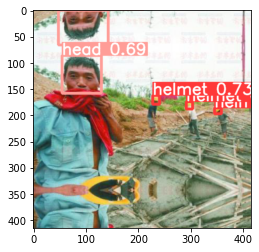

In [80]:
show_img = plt.imread(testLabel[25])
plt.imshow(show_img)
plt.show

## - From 10 epoch training times

In [41]:
!python detect.py --source /home/jarupong/Desktop/helmetDetection/Dataset/images/test  --weights runs/train/exp7/weights/best.pt --conf 0.25

detect: weights=['runs/train/exp7/weights/best.pt'], source=/home/jarupong/Desktop/helmetDetection/Dataset/images/test, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, tfl_int8=False
YOLOv5 🚀 v5.0-375-gd1182c4 torch 1.9.0 CUDA:0 (NVIDIA GeForce MX150, 2002.625MB)

Fusing layers... 
Model Summary: 224 layers, 7059304 parameters, 0 gradients, 16.3 GFLOPs
image 1/500 /home/jarupong/Desktop/helmetDetection/Dataset/images/test/hard_hat_workers1000.png: 640x640 2 helmets, Done. (0.041s)
image 2/500 /home/jarupong/Desktop/helmetDetection/Dataset/images/test/hard_hat_workers1005.png: 640x640 7 helmets, 1 head, Done. (0.040s)
image 3/500 /home/jarupong/Desktop/helmetDetection/Dataset/images/test/hard_

In [81]:
#Show detection of model on images
from IPython.display import Image
from glob import glob
import matplotlib.pyplot as plt
testLabel = glob('runs/detect/exp6/*')

<function matplotlib.pyplot.show(close=None, block=None)>

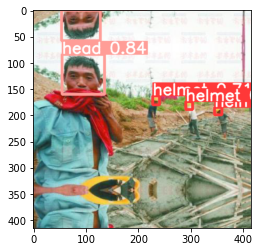

In [82]:
show_img = plt.imread(testLabel[25])
plt.imshow(show_img)
plt.show